# Классификация MNIST сверточной сетью

https://www.kaggle.com/c/digit-recognizer

In [1]:
!wget https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
!unzip digit-recognizer.zip 

--2023-06-02 19:06:19--  https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9wrovo5cugw8xdu/digit-recognizer.zip [following]
--2023-06-02 19:06:19--  https://www.dropbox.com/s/raw/9wrovo5cugw8xdu/digit-recognizer.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc682ca431537041af4b0b89efb.dl.dropboxusercontent.com/cd/0/inline/B9MzAJ9mlgSTku7vV8IKz32vU9ZIGFnK8VSTQdbDTLVn8TZZ7H5IZRUK-kw6VLLyOjhkezXeKeXKeAJPG29VbgmrPtQog9Y22j0bWsnzi9KzrutCHNQW8i0-4bmB5rU9GQqaa4rZc2WabbY8aArt4lh-xtaMVkWGWSZUBwNGUFEtrQ/file# [following]
--2023-06-02 19:06:19--  https://ucc682ca431537041af4b0b89efb.dl.dropboxusercontent.com/cd/0/inline/B9MzAJ9mlgSTku7vV8IKz32vU9ZIGFnK8VSTQdbDTLVn8TZZ7H5IZ

In [2]:
# volatil gpu-util Показывает, насколько видеокарта используется
!nvidia-smi # Данные видеокарты и GPU ТИп видеокарты  Tesla T4 память видеокарты 15360MiB CUDA Version: 12.0 - драйвер, позволяющий нейронке использовать видеокарту

Fri Jun  2 19:06:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)
print(tf.executing_eagerly())

2.12.0
True


In [4]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [5]:
train.shape, test.shape  # У трена больше, т.к еще метка класса

((42000, 785), (28000, 784))

In [7]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду - сворачиваем векторы в картинки и добавляем канал
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

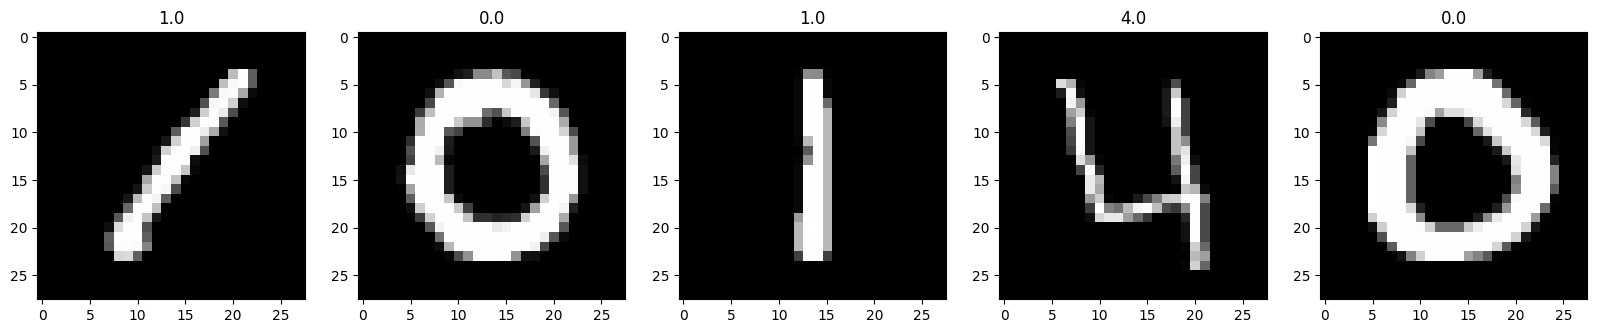

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [9]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same', # ДОбавляем рамку из 0 чтобы сохранить размер картинки
                           activation='relu',
                           input_shape=x_train.shape[1:]), # Т.к это 1 слой, нужно прописать размер входа
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(), # вытягивает тензор в вектор (N,C,H,W)->(N, C*H*W)
    # пЕредаем в многослойный персептрон со скрытым слоем 32 и выходом 10 - по числу цифр
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                2

## One-hot кодировка разметки

In [12]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [13]:
print(y_train.shape)
print(y_train_labels.shape)

(33600,)
(33600, 10)


## Запускаем обучение

In [15]:
model.fit(x_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0472 - accuracy: 0.9856 - val_loss: 0.0970 - val_accuracy: 0.9775
Epoch 2/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0454 - accuracy: 0.9860 - val_loss: 0.0914 - val_accuracy: 0.9769
Epoch 3/5
840/840 [==============================] - 5s 6ms/step - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.0912 - val_accuracy: 0.9778
Epoch 4/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.1063 - val_accuracy: 0.9772
Epoch 5/5
840/840 [==============================] - 5s 6ms/step - loss: 0.0357 - accuracy: 0.9888 - val_loss: 0.1010 - val_accuracy: 0.9768


## Предсказываем класс объекта

In [16]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

263/263 [==============================] - 1s 2ms/step


## Оцениваем качество решение на валидационной выборке

In [17]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred_labels))

Accuracy: 0.9770238095238095


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       816
         1.0       0.98      1.00      0.99       909
         2.0       0.98      0.97      0.98       846
         3.0       0.98      0.98      0.98       937
         4.0       0.95      0.99      0.97       839
         5.0       0.99      0.97      0.98       702
         6.0       0.96      0.99      0.98       785
         7.0       0.99      0.97      0.98       893
         8.0       0.97      0.97      0.97       835
         9.0       0.98      0.96      0.97       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



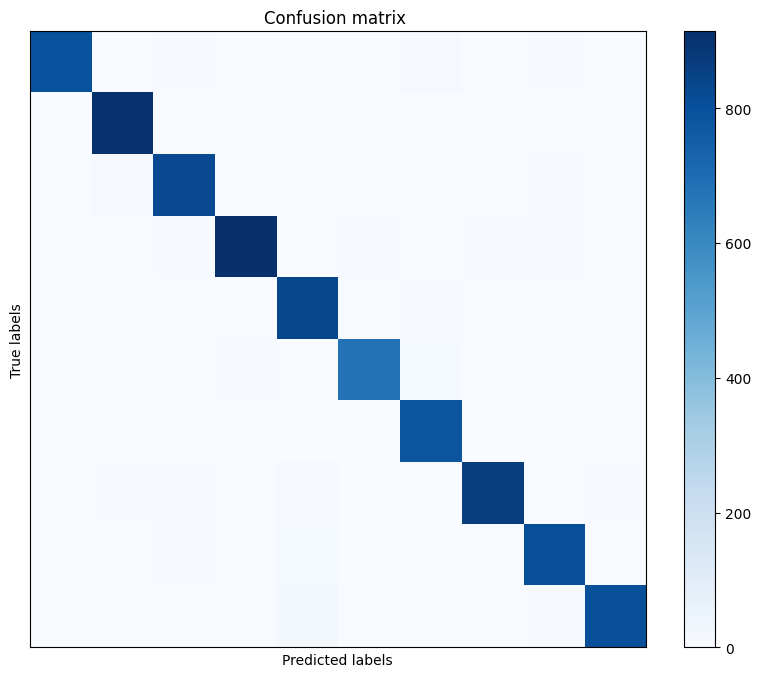

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [23]:
cm

array([[797,   0,   4,   0,   0,   0,  10,   0,   4,   1],
       [  0, 905,   0,   1,   1,   0,   1,   0,   1,   0],
       [  0,   9, 824,   1,   2,   0,   2,   2,   6,   0],
       [  0,   1,   4, 914,   0,   4,   0,   4,   7,   3],
       [  1,   0,   0,   0, 832,   0,   4,   0,   0,   2],
       [  0,   0,   0,   6,   0, 679,  13,   0,   1,   3],
       [  1,   2,   0,   0,   0,   0, 781,   0,   1,   0],
       [  0,   4,   4,   3,   8,   0,   0, 866,   1,   7],
       [  0,   2,   6,   3,  11,   2,   0,   2, 806,   3],
       [  1,   1,   0,   2,  20,   2,   0,   3,   6, 803]])

## Визуализируем предсказания для тестовой выборки

In [20]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1) # исп. argmax, т.к нам возвращаются вероятности по классам, и нужно выбрать

875/875 [==============================] - 2s 2ms/step


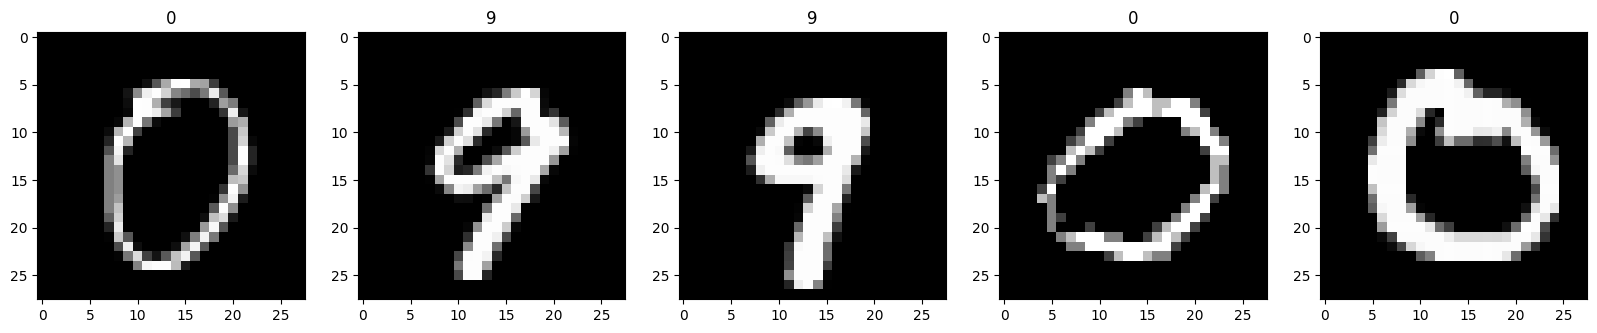

In [21]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%d' % pred);

## Готовим файл для отправки

In [22]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_labels, 1):
        dst.write('%s,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.96814